In [1]:
import warnings, os
import numpy as np
import pandas as pd
from nbeats_keras.model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [17]:
num_samples, time_steps, input_dim, output_dim = 50_000, 15, 1, 1
backend = NBeatsKeras(
        input_dim=input_dim,
        backcast_length=time_steps, forecast_length=output_dim*5,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', optimizer='adam')

forecast_length = 5
backcast_length = 3 * forecast_length

milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity. milk.shape = 168

# x: data backcast/y: forecast generation.
x, y = [], []
for epoch in range(backcast_length, len(milk) - forecast_length): # range(15, len-5):
    x.append(milk[epoch - backcast_length:epoch]) # x = backcast (0,15), (1,16)
    y.append(milk[epoch:epoch + forecast_length]) # y = forecast (15,20), (16,21)
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
# print("the c size is: ", c) # c = 118
x_train, y_train = x[:c], y[:c] # cut the first part to be training samples (80%)
x_test, y_test = x[c:], y[c:] # use the rest part to be testing samples (20%)

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant
test_size = len(x_test)
# print("test_size is:", test_size) # test_size = 30

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727


In [18]:
# check the model data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((118, 15), (118, 5), (30, 15), (30, 5))

In [19]:
# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)

# Save the model for later.
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
print("the prediction_forecast shape is:", predictions_forecast.shape) #shape: (30, 5, 1)
#np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
print("the prediction_backcast shape is:", predictions_backcast.shape) #shape: (30, 15, 1)
#np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model.h5')
predicts = model_2.predict(x_test)
print("the reloaded prediction_shape is:", predicts.shape) #shape: (30, 5, 1)
#np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6317 - val_loss: 0.5076
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4445 - val_loss: 0.3947
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.3442 - val_loss: 0.3318
Epoch 4/100
1/1 [==============================] - 0s 19ms/step - loss: 0.2886 - val_loss: 0.2914
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2511 - val_loss: 0.1990
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1735 - val_loss: 0.1163
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1071 - val_loss: 0.1005
Epoch 8/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0960 - val_loss: 0.1177
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1053 - val_loss: 0.1265
Epoch 10/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1102 - val_loss: 0.1188
Epoch 11/

1/1 [==============================] - 0s 37ms/step - loss: 0.0226 - val_loss: 0.0268
Epoch 84/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0220 - val_loss: 0.0292
Epoch 85/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0233 - val_loss: 0.0278
Epoch 86/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0231 - val_loss: 0.0268
Epoch 87/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0221 - val_loss: 0.0278
Epoch 88/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0219 - val_loss: 0.0264
Epoch 89/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0223 - val_loss: 0.0329
Epoch 90/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0236 - val_loss: 0.0256
Epoch 91/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0218 - val_loss: 0.0263
Epoch 92/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0213 - val_loss: 0.0269
Epoch 93/100
1/1 [=====

/home/stufs1/zuwang/anaconda3/envs/nbeats/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


the prediction_forecast shape is: (30, 5, 1)
the prediction_backcast shape is: (30, 15, 1)
the reloaded prediction_shape is: (30, 5, 1)


In [8]:
num_sample = len(x_test)

MAE_temp = 0.0
MSE_temp = 0.0

for i in range(num_sample):
    MAE_temp = MAE_temp + mean_absolute_error(y_test[i], predicts[i].flatten())
    MSE_temp = MSE_temp + mean_squared_error(y_test[i], predicts[i].flatten())

predictive_score_mae = MAE_temp/num_sample
predictive_score_mse = MSE_temp/num_sample
print("predictive_score_mae:", predictive_score_mae)
print("predictive_score_mse:", predictive_score_mse)

predictive_score_mae: 0.02887015582536848
predictive_score_mse: 0.00147312116647789


In [23]:
predicts[0].shape

(5, 1)

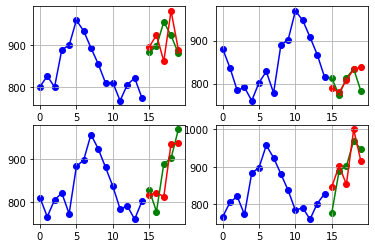

In [9]:
subplots = [221, 222, 223, 224]
plt.figure(1)
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    ff, xx, yy = predicts[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.show()